In [5]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.ndimage import filters
import imtools
%matplotlib inline

img_path = 'images/at_large.jpg'

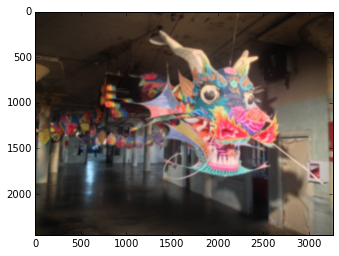

In [6]:
# Gaussian Blur Example
NUM_CHANNELS = 3

img = Image.open(img_path)

image_array = np.array(img)
filtered_image_array = np.zeros(image_array.shape)
theta = 8
for i in range(NUM_CHANNELS):
    filtered_image_array[:,:,i] = filters.gaussian_filter(image_array[:,:,i], theta)

filtered_image_array = np.uint8(filtered_image_array)    
    
plt.imshow(filtered_image_array)
plt.show()

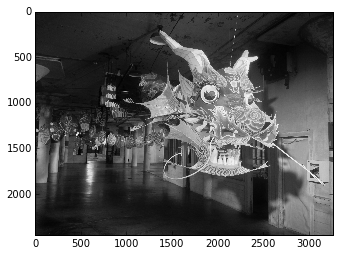

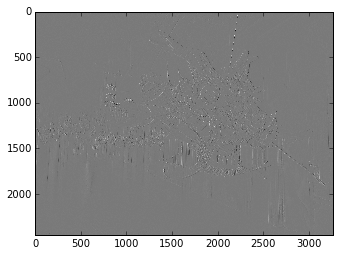

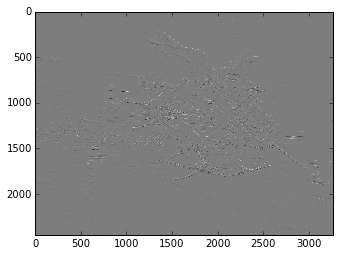

In [14]:
# Image Derivative Example
image_array = np.array(Image.open(img_path).convert('L'))
image_x = np.zeros(image_array.shape)

filters.sobel(image_array, 1, image_x)

image_y = np.zeros(image_array.shape)
filters.sobel(image_array, 0, image_y)

magnitude = np.sqrt(image_x**2+image_y**2)

plt.gray();

plt.figure()
plt.imshow(image_array)

plt.figure()
plt.imshow(image_x)

plt.figure()
plt.imshow(image_y)

plt.figure()
plt.imshow(magnitude)

plt.show()
